<h1>用注意力机制实现中英文互译</h1>

In [ ]:
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

<h2>1 导入需要的模块及数据</h2>

In [8]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import jieba
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname='/home/wumg/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h2>2 预处理数据</h2>
数据预处理步骤包括：

1）读取txt文件，并按行分割，再把每一行分割成一个pair(lan1,lan2)

2）过滤并处理文本信息

3）从每个pair中，制作出中文词典和英文词典

4）构建数据集


In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    def addSentence_cn(self, sentence):
        for word in list(jieba.cut(sentence)):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [22]:
# 为便于数据处理，把Unicode字符串转换为ASCII编码

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 对英文转换为小写，去空格及非字母符号等处理
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [23]:
lines = open('cmn-eng/cmn.txt', encoding='utf-8').\
        read().strip().split('\n')
pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
pairs

[['hi .', '嗨。'],
 ['hi .', '你好。'],
 ['run .', '你用跑的。'],
 ['wait !', '等等！'],
 ['hello !', '你好。'],
 ['i try .', '让我来。'],
 ['i won !', '我赢了。'],
 ['oh no !', '不会吧。'],
 ['cheers !', '乾杯 !'],
 ['got it ?', '你懂了吗？'],
 ['he ran .', '他跑了。'],
 ['hop in .', '跳进来。'],
 ['i lost .', '我迷失了。'],
 ['i quit .', '我退出。'],
 ["i'm ok .", '我沒事。'],
 ['listen .', '听着。'],
 ['no way !', '不可能！'],
 ['no way !', '没门！'],
 ['really ?', '你确定？'],
 ['try it .', '试试吧。'],
 ['we try .', '我们来试试。'],
 ['why me ?', '为什么是我？'],
 ['ask tom .', '去问汤姆。'],
 ['be calm .', '冷静点。'],
 ['be fair .', '公平点。'],
 ['be kind .', '友善点。'],
 ['be nice .', '和气点。'],
 ['call me .', '联系我。'],
 ['call us .', '联系我们。'],
 ['come in .', '进来。'],
 ['get tom .', '找到汤姆。'],
 ['get out !', '滾出去！'],
 ['get out !', '出去！'],
 ['go away !', '走開！'],
 ['go away !', '滾！'],
 ['go away .', '走開！'],
 ['goodbye !', '再见！'],
 ['goodbye !', '告辞！'],
 ['hang on !', '等一下！'],
 ['he came .', '他来了。'],
 ['he runs .', '他跑。'],
 ['help me .', '帮我一下。'],
 ['help us .', '帮帮我们吧！'],
 ['hold on

In [27]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 读文件，然后分成行
    # strip() 函数 来删除字符串 之前和之后的 空格，
    lines = open('cmn-eng/cmn.txt', encoding='utf-8').\
        read().strip().split('\n')

    # 把行分成语句对，并进行规范化。
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 判断是否需要转换语句对的次序，如[英文，中文]转换为[中文，英文]次序
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs=readLangs('eng', 'cmn', reverse=False)
print(input_lang,output_lang)
pairs

Reading lines...
<__main__.Lang object at 0x00000201C38FA748> <__main__.Lang object at 0x00000201D822B208>


[['hi .', '嗨。'],
 ['hi .', '你好。'],
 ['run .', '你用跑的。'],
 ['wait !', '等等！'],
 ['hello !', '你好。'],
 ['i try .', '让我来。'],
 ['i won !', '我赢了。'],
 ['oh no !', '不会吧。'],
 ['cheers !', '乾杯 !'],
 ['got it ?', '你懂了吗？'],
 ['he ran .', '他跑了。'],
 ['hop in .', '跳进来。'],
 ['i lost .', '我迷失了。'],
 ['i quit .', '我退出。'],
 ["i'm ok .", '我沒事。'],
 ['listen .', '听着。'],
 ['no way !', '不可能！'],
 ['no way !', '没门！'],
 ['really ?', '你确定？'],
 ['try it .', '试试吧。'],
 ['we try .', '我们来试试。'],
 ['why me ?', '为什么是我？'],
 ['ask tom .', '去问汤姆。'],
 ['be calm .', '冷静点。'],
 ['be fair .', '公平点。'],
 ['be kind .', '友善点。'],
 ['be nice .', '和气点。'],
 ['call me .', '联系我。'],
 ['call us .', '联系我们。'],
 ['come in .', '进来。'],
 ['get tom .', '找到汤姆。'],
 ['get out !', '滾出去！'],
 ['get out !', '出去！'],
 ['go away !', '走開！'],
 ['go away !', '滾！'],
 ['go away .', '走開！'],
 ['goodbye !', '再见！'],
 ['goodbye !', '告辞！'],
 ['hang on !', '等一下！'],
 ['he came .', '他来了。'],
 ['he runs .', '他跑。'],
 ['help me .', '帮我一下。'],
 ['help us .', '帮帮我们吧！'],
 ['hold on

In [28]:
#为便于训练，这里选择部分数据
MAX_LENGTH = 20

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# 这里为了方便训练，只选取了以上面这些开头的且长度小于20个单词的句子进行训练
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

pairs=filterPairs(pairs)
pairs

[]

In [29]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence_cn(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [30]:
input_lang, output_lang, pairs = prepareData('eng', 'cmn',True)
print(random.choice(pairs))

Reading lines...
Read 21007 sentence pairs
Trimmed to 640 sentence pairs
Counting words...
Counted words:
cmn 1063
eng 808
['他是这么的无情。', 'he is so heartless .']


In [31]:
pairs[:3]

[['我冷。', 'i am cold .'], ['我沒事。', 'i am okay .'], ['我生病了。', 'i am sick .']]

In [32]:
pairs

[['我冷。', 'i am cold .'],
 ['我沒事。', 'i am okay .'],
 ['我生病了。', 'i am sick .'],
 ['我个子高。', 'i am tall .'],
 ['他很凶。', 'he is mean .'],
 ['他很穷。', 'he is poor .'],
 ['他高。', 'he is tall .'],
 ['我是个男人。', 'i am a man .'],
 ['我个头矮。', 'i am short .'],
 ['他獨自一人。', 'he is alone .'],
 ['他醉了。', 'he is drunk .'],
 ['我來了。', 'i am coming .'],
 ['我們是男孩。', 'we are boys .'],
 ['我們遲到了。', 'we are late .'],
 ['我在家。', 'i am at home .'],
 ['我很好奇。', 'i am curious .'],
 ['我结婚了。', 'i am married .'],
 ['我在祈禱。', 'i am praying .'],
 ['我渴了。', 'i am thirsty .'],
 ['她很安静。', 'she is quiet .'],
 ['她心情不好。', 'she is upset .'],
 ['我們很快樂。', 'we are happy .'],
 ['这是一个小偷。', 'he is a thief .'],
 ['他在家裡。', 'he is at home .'],
 ['他是我的菜 !', 'he is my type !'],
 ['他不是傻子。', 'he is no fool .'],
 ['他没疯。', 'he is no fool .'],
 ['他现在出去了。', 'he is out now .'],
 ['我离婚了。', 'i am divorced .'],
 ['我很难过。', 'i am very sad .'],
 ['你喝醉了！', 'you are drunk !'],
 ['你在撒谎。', 'you are lying .'],
 ['他是美国人。', 'he is american .'],
 ['我是匈牙利人。', 'i am hung

<h2>3 构建模型</h2>


![encoder](./simple_encoder_decoder.png "Magic Gardens")


In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device) 

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [23]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [24]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def indexesFromSentence_cn(lang, sentence):
    return [lang.word2index[word] for word in list(jieba.cut(sentence))]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromSentence_cn(lang, sentence):
    indexes = indexesFromSentence_cn(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence_cn(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

<h2>4 训练模型</h2>

In [25]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [26]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [27]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  
    plot_loss_total = 0 

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [29]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence_cn(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [30]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

4m 45s (- 66m 38s) (5000 6%) 2.6559
11m 3s (- 71m 50s) (10000 13%) 1.1740
17m 24s (- 69m 39s) (15000 20%) 0.2202
23m 51s (- 65m 36s) (20000 26%) 0.0484
30m 30s (- 61m 1s) (25000 33%) 0.0268
36m 58s (- 55m 27s) (30000 40%) 0.0200
44m 9s (- 50m 28s) (35000 46%) 0.0215
50m 12s (- 43m 55s) (40000 53%) 0.0145
56m 37s (- 37m 45s) (45000 60%) 0.0169
63m 37s (- 31m 48s) (50000 66%) 0.0125
68m 40s (- 24m 58s) (55000 73%) 0.0144
75m 3s (- 18m 45s) (60000 80%) 0.0128
80m 15s (- 12m 20s) (65000 86%) 0.0123
85m 38s (- 6m 7s) (70000 93%) 0.0131
90m 46s (- 0m 0s) (75000 100%) 0.0123


<Figure size 432x288 with 0 Axes>

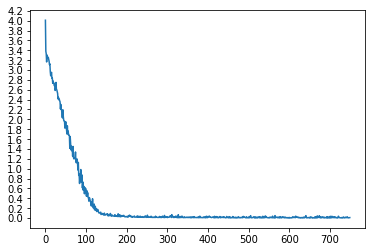

In [31]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

<h2>5随机采样，对模型进行测试</h2>

In [32]:
evaluateRandomly(encoder1, attn_decoder1)

> 我們明天要離開。
= we are going to leave tomorrow .
< we are going to leave tomorrow . <EOS>

> 我不是個老師。
= i am not a teacher .
< i am not a teacher . <EOS>

> 我來自靜岡。
= i am from shizuoka .
< i am from shizuoka . <EOS>

> 你不是个懦夫。
= you are not a coward .
< you are not a coward . <EOS>

> 他不是老師，而是醫生。
= he is not a teacher but a doctor .
< he is not a teacher but a doctor . <EOS>

> 他是我最年轻的兄弟。
= he is my youngest brother .
< he is my youngest brother . <EOS>

> 他不因貧窮而感到羞愧。
= he is not ashamed of being poor .
< he is not ashamed of being poor . <EOS>

> 他说法语说得很流利。
= he is fluent in french .
< he is fluent in french . <EOS>

> 他还在这儿。
= he is still here .
< he is still here . <EOS>

> 我對法語很感興趣。
= i am very interested in french .
< i am very interested in french . <EOS>



In [33]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [34]:
def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')